# Example script for the TailCutsDataVolumeReducer

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ctapipe
from ctapipe.io import event_source
from ctapipe import utils
from ctapipe.calib import CameraCalibrator
from ctapipe.visualization import CameraDisplay
from ctapipe.image.reducer import TailCutsDataVolumeReducer
from ctapipe.instrument import CameraGeometry

### 1) Import data

In [2]:
data = utils.get_dataset_path("gamma_test_large.simtel.gz")
source = event_source(data, allowed_tels=[1,2,3,4],  max_events=2)

### 2.1) First variant
Simple way with CameraCalibrator.
 - Define reduction parameters in loop. Default values are: <br>
&emsp; picture_thresh = 10 <br>
&emsp; boundary_thresh = 5 <br>
&emsp; end_dilates = 1 <br>
&emsp; keep_isolated_pixels = True <br>
&emsp; min_number_picture_neighbors = 0
 - Use TailCutsDataVolumeReducer in CameraCalibrator
 - Get reduced image
 - Plot image

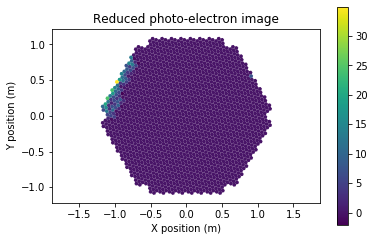

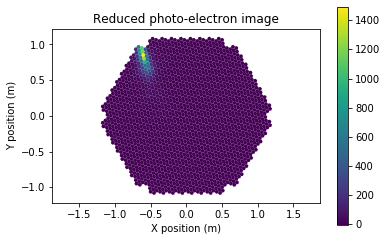

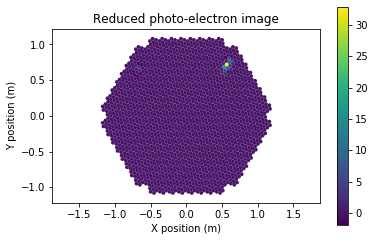

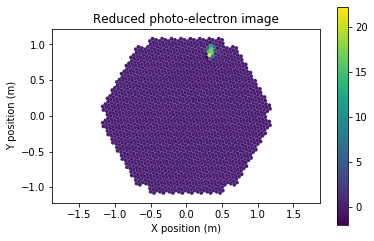

In [3]:
#loop over events
for event in source:
    subarray = event.inst.subarray
    # VolumeReducer
    volume_reducer = TailCutsDataVolumeReducer(subarray=subarray)
    # reduction parameters
    volume_reducer.picture_thresh = 10
    volume_reducer.boundary_thresh = 5
    volume_reducer.end_dilates = 1
    volume_reducer.keep_isolated_pixels = True
    volume_reducer.min_number_picture_neighbors = 0
    # calibrate
    calib = CameraCalibrator(data_volume_reducer=volume_reducer,
                             subarray=subarray)
    calib(event)
    # loop over telescopes
    for tel_id in event.dl0.tels_with_data:
        
        # get reduced image
        reduced_pe_image = event.dl1.tel[tel_id].image
        
        # plot reduced image
        camera = subarray.tel[tel_id].camera.geometry
        disp = CameraDisplay(camera, image=reduced_pe_image)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Reduced photo-electron image")
        disp.add_colorbar()
        cb1 = disp.colorbar
        plt.show()

### 2.2) Second variant
For comparative studies - Here you can make a comparison between the reduced and unreduced image.
 - Define reduction parameters in loop. Default values are: <br>
&emsp; picture_thresh = 10 <br>
&emsp; boundary_thresh = 5 <br>
&emsp; end_dilates = 1 <br>
&emsp; keep_isolated_pixels = True <br>
&emsp; min_number_picture_neighbors = 0
 - Use NullDataVolumeReducer in CameraCalibrator (default)
 - Get Waveforms (DL0) and unreduced image (DL1)
 - Use TailCutsDataVolumeReducer manually on waveforms (DL0) and get mask 
 - Use mask on unreduced image (DL1) and get reduced image
 - Plot reduced and unreduced image

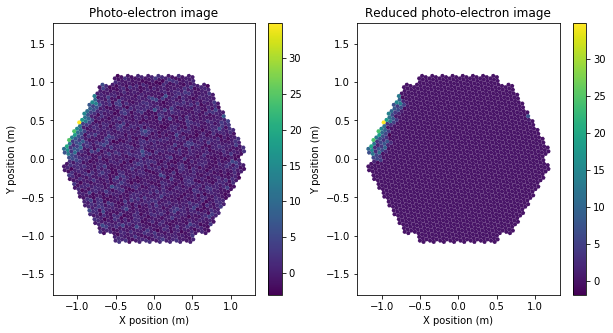

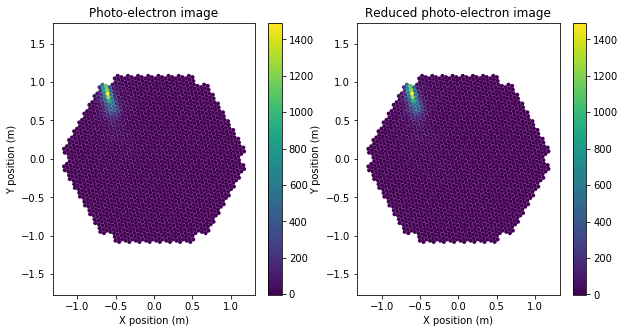

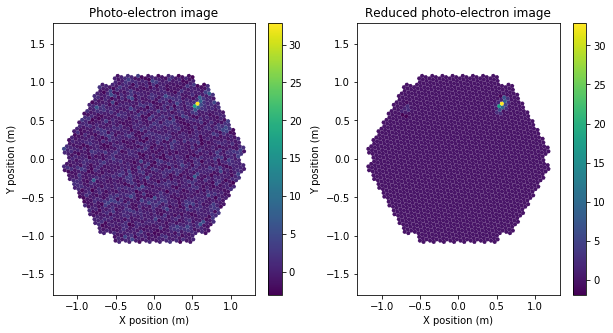

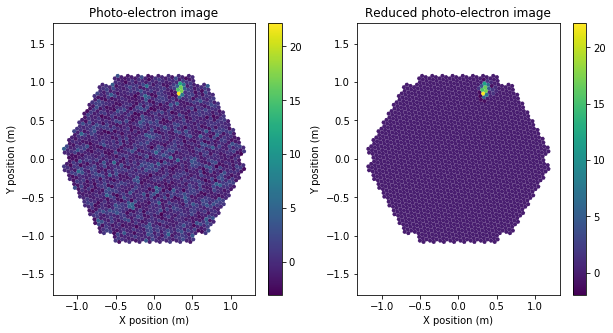

In [3]:
# loop over events
for event in source:
    subarray = event.inst.subarray
    # VolumeReducer
    volume_reducer = TailCutsDataVolumeReducer(subarray=subarray)
    # reduction parameters
    volume_reducer.picture_thresh = 10
    volume_reducer.boundary_thresh = 5
    volume_reducer.end_dilates = 1
    volume_reducer.keep_isolated_pixels = True
    volume_reducer.min_number_picture_neighbors = 0
    # calibrate
    calib = CameraCalibrator(subarray=subarray)
    calib(event)
    # loop over telescopes
    for tel_id in event.dl0.tels_with_data:
        
        # get camera images
        waveforms = event.dl0.tel[tel_id].waveform
        pe_image = event.dl1.tel[tel_id].image

        # reduction
        selected_gain_channel = event.r1.tel[tel_id].selected_gain_channel
        reduced_pe_image = pe_image.copy()
        mask = volume_reducer(waveforms, telid=tel_id, 
                              selected_gain_channel=selected_gain_channel
        )
        reduced_pe_image[~mask] = 0

        # plot reduced and unreduced image
        camera = subarray.tel[tel_id].camera.geometry
        plt.figure(figsize=(10,5))
        ax1 = plt.subplot(121)
        disp1 = CameraDisplay(camera, image=pe_image)
        disp1.add_colorbar()
        ax1.set_title("Photo-electron image")
        ax2 = plt.subplot(122)
        disp2 = CameraDisplay(camera, image=reduced_pe_image)
        disp2.add_colorbar()
        ax2.set_title("Reduced photo-electron image")
        plt.show()
